# Importing packages


In [1]:
! pip install nltk
! pip install gensim
! pip install imbalanced-learn

import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
warnings.filterwarnings(action = 'ignore')
  

import random
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, auc, precision_recall_curve, plot_roc_curve, classification_report, average_precision_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data loading

The associations are based RepoDB database and collected from golden standard database of our prior study, DRP-VEM.

In [2]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = A.copy()

# making the drug and disease lists

my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))

Text(0.5, 1.0, 'Type')

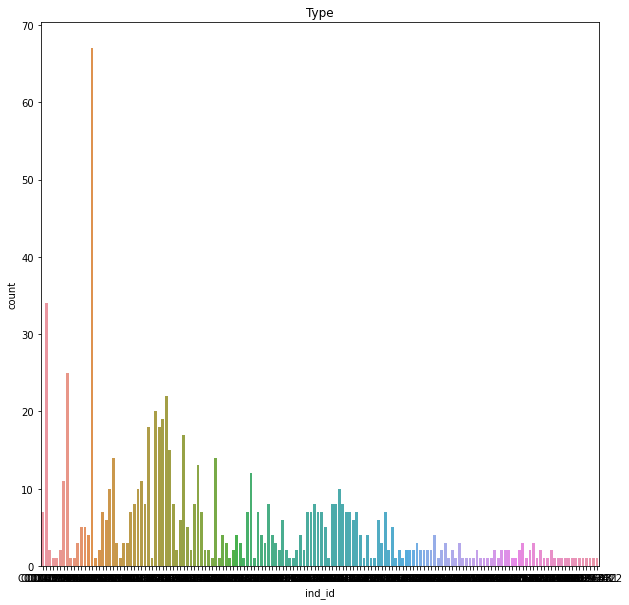

In [3]:
# The frequency of drug-id and indication id

sns.countplot(ass['ind_id'])
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Type')

In [4]:
freq = ass.groupby(['ind_id'])['drug_id'].agg('count').reset_index()
freq = freq.sort_values(by='drug_id', ascending=False)


The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [5]:
disease=pd.read_csv("/content/drive/MyDrive/RepoDB/DisGeNet/curated_gene_disease_associations.tsv", delimiter="\t")
database_disease_list= list(set(disease.diseaseId))

# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disease.iterrows():
  if row.diseaseId in my_disease_list:
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [6]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [7]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c

In [8]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [9]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [10]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

In [11]:
has = pd.read_csv("my_repodb.txt") # Positive data
has.set_index("Unnamed: 0", inplace=True)

hasnt = pd.read_csv("my_only_negatives.txt") # Negative data
hasnt.set_index("Unnamed: 0", inplace=True)

In [12]:
A_test=[]
i=0
# randomly chose 10% (78) of positive data for test set
# then extract those pairs from the documnet of associations that word2vec learns
while(i!=78):
  a1 = (random.sample(A, 1))
  a = a1[0].split(" ")
  a2=a[2].split(".")
  if a2[0] in database_disease_list:
    A_test.append(a1[0])
    A.remove(a1[0]) # removing the drug-disease pairs that we aim to check their associations by the model
    i+=1

ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

In [13]:
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
print("The number of all known drug disease associations in our dataset: ",(has.shape))

I=[]
for idx, row in has.iterrows():
  text=str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if text in A_test: # Extracting test associations from positive data
    I.append(idx)
has = has.drop(index=I, axis=0)
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of all known drug disease associations in our dataset:  (778, 2)
The number of  known drug disease associations without positive test set: (700, 2)


In [14]:
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))

I=[]
u=0
hasnt_test_idx=random.sample(range(0,hasnt.shape[0]), 78)
for idx, row in hasnt.iterrows():
  if idx in hasnt_test_idx:
    I.append(row)
    x = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "  # we extract those has_sideeffect relations from drug which are in negative test set and we consider them as adverse drug reactions
    if(x in S):
      S.remove(x)
      u = u+1
hasnt = hasnt.drop(index=hasnt_test_idx, axis=0)
print("The number of unknown drug disease associations without negative test set: ",(hasnt.shape))

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)


The number of unknown drug disease associations in our dataset:  (1969, 2)
The number of unknown drug disease associations without negative test set:  (1891, 2)


#Word2Vec implementation


first, we make the file of our DDKG


In [ ]:

data=[]
sets=[chemical, target, side, domain, atccode, ass, Disease]

for s in sets:
  for i in sent_tokenize(s):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

In [ ]:
word_freq = defaultdict(int)
for sent in data:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

10076

we train Word2Vec-CBOW for embedding every entity of DDKG including diseases and drugs

based on trial and error, the best performance of Word2Vec on our dataset is when the length of vectors (size) is 700 and the iteration (iter) is 2000

In [ ]:
model1 = gensim.models.Word2Vec(min_count = 1, alpha=0.001, size = 700, window = 2, iter=2000, sg=0)
model1.build_vocab(data, progress_per=10000)
model1.train(data, total_examples=model1.corpus_count, epochs=500, report_delay=1)
model1.init_sims(replace=True)

In [ ]:
def mean_cal(K):
  sum=0
  for k in K:
    sum= sum+k
  return(sum/len(K))

# Implementation

we consider several approaches:
1. unbalanced dataset (1961 negativ and 700 positive)
2. Undersampling negative data 
3. Upsampling positive data
4. Upsampling positive data and undersampling negative data

## Unbalanced

In [ ]:
frames = [has, hasnt]
f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
# first time, we split dataset 5 times and average the results
# Notice: here, we only work on trained vocabulary. and the test set is not evaluated yet

sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  # clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  # y_hat= clf.predict_proba(x_test)[:, 1]
  y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.8099704955992381
aupr =  0.7306269686311005
auc =  0.8638118037912841
aupr =  0.7973980763709446
auc =  0.8395306753838072
aupr =  0.7878618152117363
auc =  0.8496043491392329
aupr =  0.7828800865075375
auc =  0.8572804314329738
aupr =  0.7950353013337509
____________________
Mean AUC: 0.8440395510693073 
 Mean aupr: 0.778760449611014 
 Mean acc:  0.8484567901234568


auc =  0.8210610629476065
aupr =  0.6409886880677241
Score =  0.7109826589595376
_____________________
auc =  0.925774754346183
aupr =  0.8359009736282694
Score =  0.859073359073359
_____________________
auc =  0.9241591080876795
aupr =  0.830266950346627
Score =  0.8146718146718147
_____________________
auc =  0.9391345427059713
aupr =  0.8736854081702358
Score =  0.8822393822393823
_____________________
auc =  0.9042517006802722
aupr =  0.7867935817838346
Score =  0.8243243243243243
_____________________
Mean AUC: 0.9028762337535425
Mean AUPR: 0.7935271203993383
Mean Score: 0.8182583078536835
________________________


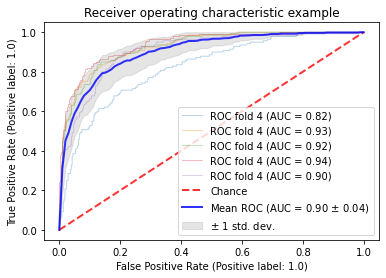

In [ ]:
# the second times, we aplly stratifiedkfold

skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")

print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("Mean Score:",mean_cal(score))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.8773833004602235
auc-pr =  0.8337218858767923
0.8408956997865287
Acc =  0.7884615384615384
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        78
           1       0.83      0.73      0.78        78

    accuracy                           0.79       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.79      0.79      0.79       156



## Undersampling negative data

In [ ]:
neg =hasnt.copy()
neg = neg.sample(n = has.shape[0]) #undersampling negative data randomly for training the model
frames = [has, neg]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:

sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  # y_hat= clf.predict_proba(x_test)[:, 1]
  y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.8658217925267834
aupr =  0.896046511627907
auc =  0.8428571428571429
aupr =  0.8884448462929475
auc =  0.809065934065934
aupr =  0.8654945054945056
auc =  0.8625816993464052
aupr =  0.9002869352869353
auc =  0.8636170282386048
aupr =  0.9063544106167056
____________________
Mean AUC: 0.8487887194069741 
 Mean aupr: 0.8913254418638002 
 Mean acc:  0.8485714285714285


auc =  0.886530612244898
aupr =  0.8724821017718907
Score =  0.8107142857142857
_____________________
auc =  0.9093112244897958
aupr =  0.904382534788369
Score =  0.8178571428571428
_____________________
auc =  0.9353316326530612
aupr =  0.9245916281579591
Score =  0.8857142857142857
_____________________
auc =  0.926734693877551
aupr =  0.9190167268371268
Score =  0.8428571428571429
_____________________
auc =  0.937142857142857
aupr =  0.9438944641092724
Score =  0.875
_____________________
Mean Score: 0.8464285714285715
Mean AUC: 0.9190102040816326
Mean AUPR: 0.9128734911329236
________________________


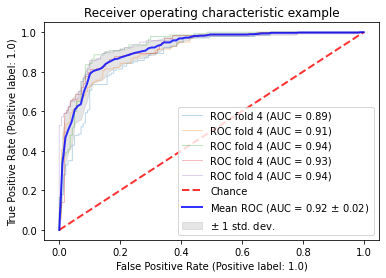

In [ ]:

skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

## Upsampling positive data

In [ ]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
oversample = SMOTE() # over sampling positive by SMOTE
# oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)

In [ ]:


sauc=[]
sacc=[]
spr=[]
for i in range(5):
  
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  y_hat= clf.predict_proba(x_test)[:, 1]
  # y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.9320404646270226
aupr =  0.9360361522730384
auc =  0.9395595775960988
aupr =  0.9222376829984636
auc =  0.9413940740209952
aupr =  0.942806396986836
auc =  0.9265233936564577
aupr =  0.9206655049244393
auc =  0.9302913551077759
aupr =  0.920755103988498
____________________
Mean AUC: 0.93396177300167 
 Mean aupr: 0.928500168234255 
 Mean acc:  0.8553911205073996


In [ ]:
skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

## First oversample, Next Undersample

In [ ]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

In [ ]:
sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="sag", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  y_hat= clf.predict_proba(x_test)[:, 1]
  # y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.9197688459548043
aupr =  0.9149094591146093
Score =  0.8340675477239354
_____________________
auc =  0.939878385371744
aupr =  0.9358710569583854
Score =  0.8707782672540382
_____________________
auc =  0.9458477508650519
aupr =  0.9432159477564772
Score =  0.8632352941176471
_____________________
auc =  0.9284429065743943
aupr =  0.9230172070222364
Score =  0.8573529411764705
_____________________
auc =  0.9325
aupr =  0.9198595139432404
Score =  0.8426470588235294
_____________________
Mean Score: 0.8536162218191242
Mean AUC: 0.9332875777531988
Mean AUPR: 0.9273746369589897
________________________


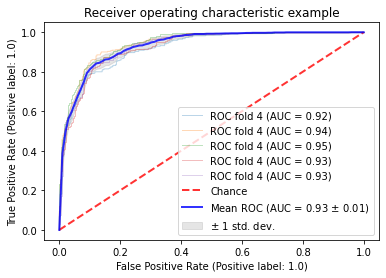

In [ ]:
skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced', max_iter=10000).fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.8788625904010519
auc-pr =  0.833675658852325
0.8408655869538266
Acc =  0.782051282051282
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        78
           1       0.81      0.73      0.77        78

    accuracy                           0.78       156
   macro avg       0.79      0.78      0.78       156
weighted avg       0.79      0.78      0.78       156



#Test the model on 
rf+ovun+5+150+concat


In [ ]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

3592
3402


In [ ]:
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  # X_me.append((model1[(dname.rstrip().lower())]- model1[(disname[0].lstrip().lower())]))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

In [ ]:
clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) # penalti should be changed
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("aupr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Score = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc =  0.8782051282051282
aupr =  0.8343833283168789
0.8415509167417345
Score =  0.7948717948717948
              precision    recall  f1-score   support

           0       0.77      0.85      0.80        78
           1       0.83      0.74      0.78        78

    accuracy                           0.79       156
   macro avg       0.80      0.79      0.79       156
weighted avg       0.80      0.79      0.79       156



auc =  0.8790269559500329
aupr =  0.8366357006988545
Score =  0.7884615384615384
_____________________
auc =  0.8782051282051282
aupr =  0.8361861068845176
Score =  0.782051282051282
_____________________
auc =  0.8800131492439185
aupr =  0.8368043618774486
Score =  0.7948717948717948
_____________________
auc =  0.8754109138724523
aupr =  0.8342868654068767
Score =  0.8012820512820513
_____________________
auc =  0.8791913214990138
aupr =  0.8349816682940633
Score =  0.7884615384615384
_____________________
auc =  0.8775476660092045
aupr =  0.8338139409397762
Score =  0.8012820512820513
_____________________
auc =  0.8780407626561473
aupr =  0.8347037378335262
Score =  0.7884615384615384
_____________________
auc =  0.8767258382642997
aupr =  0.8338727169823523
Score =  0.7884615384615384
_____________________
auc =  0.8767258382642998
aupr =  0.8349353096805588
Score =  0.7948717948717948
_____________________
auc =  0.8777120315581854
aupr =  0.8349957473632158
Score =  0.7756410256

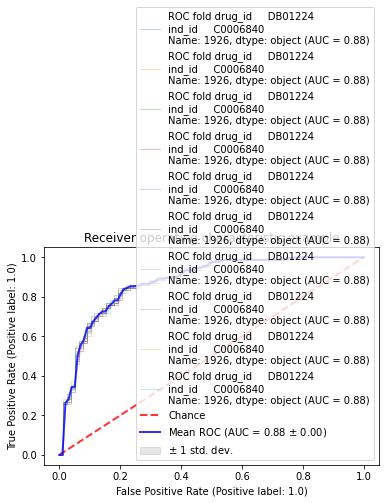

In [ ]:
skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
final_result = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000).fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, X_me, Y_me,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(X_me)[:,1]
    #  y_hat= clf.predict(X_me)
     final_result.append(y_hat)
     
     A = roc_auc_score(Y_me, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(X_me, Y_me)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'  % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

# Evaluation on Skin related disease

We consider atopic eczema and contact dermatities as test case to show how much it can generalized

For this purpose, we should design our DDKG again without considering negative or positive associations

In [15]:
skin_disease=['C0011615']
# skin_disease=['C0011616']

In [16]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = A.copy()

# making the drug and disease lists

my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))

In [17]:
disease=pd.read_csv("/content/drive/MyDrive/RepoDB/DisGeNet/curated_gene_disease_associations.tsv", delimiter="\t")
database_disease_list= list(set(disease.diseaseId))

# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disease.iterrows():
  if row.diseaseId in my_disease_list:
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [18]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [19]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c

In [20]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [21]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [22]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

In [23]:
has = pd.read_csv("my_repodb.txt") # Positive data
has.set_index("Unnamed: 0", inplace=True)

hasnt = pd.read_csv("my_only_negatives.txt") # Negative data
hasnt.set_index("Unnamed: 0", inplace=True)

In [24]:
A_test=[]
for d in my_drug_list:
  text = str(d)+" has_indicated C0011615. " 
  if text in associations:
    A.remove(text)
    A_test.append(text)
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

In [25]:
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
print("The number of all known drug disease associations in our dataset: ",(has.shape))

I=[]
for idx, row in has.iterrows():
  text=str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if text in A_test: # Extracting test associations from positive data
    I.append(idx)
has = has.drop(index=I, axis=0)
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of all known drug disease associations in our dataset:  (778, 2)
The number of  known drug disease associations without positive test set: (763, 2)


In [26]:
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})

I=[]
u=0

hasnt_test_idx=[]
for idx, row in hasnt.iterrows():
 if row.ind_id == "C0011615":
  #  print(row)
   text = str(row.drug_id)+" has_sideeffect C0011615. "
   if(text in S):
     hasnt_test_idx.append(idx)
     I.append(row)
     S.remove(text)
     u+=1

hasnt = hasnt.drop(index=hasnt_test_idx, axis=0)
hasnt.shape

I=pd.DataFrame(I)

side=""
for c in S:
  side= side+c

##Word2Vec implementation


first, we make the file of our DDKG


In [27]:
data=[]
sets=[chemical, target, side, domain, atccode, ass, Disease]

for s in sets:
  for i in sent_tokenize(s):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

In [28]:
model1 = gensim.models.Word2Vec(min_count = 1, alpha=0.001, size = 700, window = 2, iter=2000, sg=0)
model1.build_vocab(data, progress_per=10000)
model1.train(data, total_examples=model1.corpus_count, epochs=500, report_delay=1)
model1.init_sims(replace=True)

In [29]:
def mean_cal(K):
  sum=0
  for k in K:
    sum= sum+k
  return(sum/len(K))

## training a logistic regression

In [30]:
frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [31]:
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

3665
3472


In [32]:
X_me = []
Y_me = []

for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  # X_me.append((model1[(dname.rstrip().lower())]- model1[(disname[0].lstrip().lower())]))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

In [35]:
clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) # penalti should be changed
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("aupr = ", PR)


auc =  0.9666666666666667
aupr =  0.9053747287570817


Now, we calculate the association score between our disease and all drugs to find the first 10 reltaed drugs to them

In [36]:
skin_disease=['C0011615']

SCOR_PD=pd.DataFrame(columns={"Dis_id", "Drug_id", "Score"}) # To save association score
for dis in skin_disease:
  for drug in my_drug_list:
    x=np.concatenate((model1[(drug).lower()], model1[(dis).lower()]), axis=None)
    # x= x.reshape(-1, 1)
    s = clf.predict_proba([x])[:,1]
    # s = clf.predict([x])
    df2 = {"Dis_id":dis, "Drug_id":drug, "Score":s}
    SCOR_PD = SCOR_PD.append(df2, ignore_index = True)


In [39]:
top10_drugs=[]  
for dis in skin_disease:
  dis_pd = SCOR_PD[SCOR_PD.Dis_id == dis]
  m = dis_pd.Score.max()
  dis_pd = dis_pd.sort_values(by='Score', ascending=False) # First we sort the scores
  dis_pd = dis_pd.head(10) # Extract the top 10
  sum=0 
  
  for idx, row in dis_pd.iterrows():
    text = str(row.Drug_id)+' has_indicated '+str(dis)+'. '   # Check is there any association between them in our dataset or not
    if text in associations:
      sum+=1 # if there is, we count it
    all=0
    for d in my_drug_list:  # Here we find the number of all related drugs to the disease
      text = str(d)+' has_indicated '+str(dis)+'. '
      if text in associations:
        all+=1
        # print(text)
  if(all!=0):
    print("All:", all, "Sum:", sum)
    if(all>10):
      top10_drugs.append(sum/10)  
    else:
      top10_drugs.append(sum/all)
  else:
    top10_drugs.append(0)

All: 15 Sum: 6


###find unknown associations


In [44]:
for id in skin_disease:
  dis_pd = SCOR_PD[SCOR_PD.Dis_id==id]
  dis_pd = dis_pd.sort_values(by='Score', ascending=False)
  dis_pd = dis_pd.head(10)
  for idx, row in dis_pd.iterrows():
    text = str(row.Drug_id)+' has_indicated '+str(row.Dis_id)+'. '
    if not(text in associations):
      print(text)


DB00394 has_indicated C0011615. 
DB00324 has_indicated C0011615. 
DB01047 has_indicated C0011615. 
DB00838 has_indicated C0011615. 
